In [1]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics_flat
from particle import literals as lp
from fcc_python_tools import plotting
import pandas as pd
from root_pandas import to_root

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

Welcome to JupyROOT 6.20/06


/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.18.5 is currently installed but you installed root_numpy against numpy 1.16.4. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [2]:
file_name = "p8_ee_Zbb_ecm91_EvtGen_Bu2TauNuTAUHADNU"

file = uproot.open(f"/eos/experiment/fcc/ee/tmp/flatntuples/Z_Zbb_Bc2TauNu_v02/{file_name}.root")
tree = file['events']

In [3]:
#Load the event-level variables
events = tree.arrays(filter_name="EVT_*")

In [4]:
#Hemisphere energies
for hem in ["0","1"]:
    events[f"EVT_thrutshemis{hem}_e"] = events[f"EVT_thrutshemis{hem}_echarged"] + events[f"EVT_thrutshemis{hem}_eneutral"]

#Total energy (sum of both hemispheres)
events["EVT_e"] = events["EVT_thrutshemis0_e"] + events["EVT_thrutshemis1_e"]

#Min and max hemisphere energies per-event
events["EVT_thrutshemis_e_min"] = np.minimum(events["EVT_thrutshemis0_e"],events["EVT_thrutshemis1_e"])
events["EVT_thrutshemis_e_max"] = np.maximum(events["EVT_thrutshemis0_e"],events["EVT_thrutshemis1_e"])

#Difference in energy between hemispheres (max - min so always positive)
events["EVT_thrutshemis_e_diff"] = events["EVT_thrutshemis_e_max"] - events["EVT_thrutshemis_e_min"]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


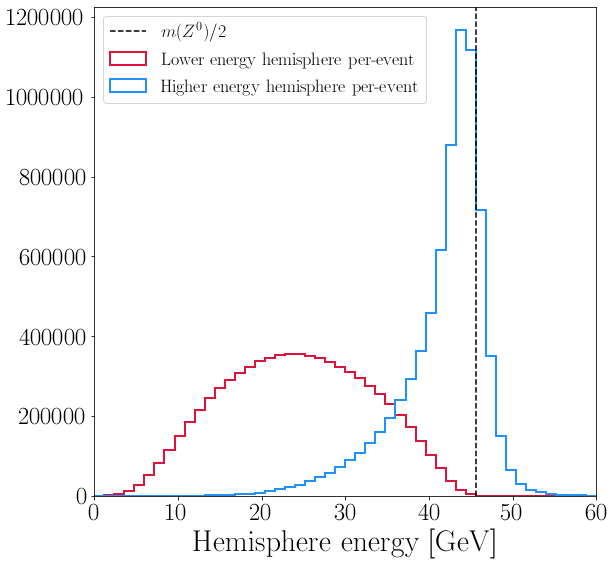

In [5]:
fig, ax = plt.subplots(figsize=(9,9))
plt.hist(events["EVT_thrutshemis_e_min"],bins=50,range=(0,60),color="crimson",histtype='step',linewidth=2,label="Lower energy hemisphere per-event")
plt.hist(events["EVT_thrutshemis_e_max"],bins=50,range=(0,60),color="dodgerblue",histtype='step',linewidth=2,label="Higher energy hemisphere per-event")
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(0,60)
plt.axvline(lp.Z_0.mass/2000., color='k',linestyle='--',label="$m(Z^0)/2$")
plt.xlabel("Hemisphere energy [GeV]",fontsize=30)
plt.legend(fontsize=18, loc="upper left")
plt.show()
fig.savefig(f"{loc.PLOTS}/Bu2TauNu_min_max_hemisphere_E.pdf")

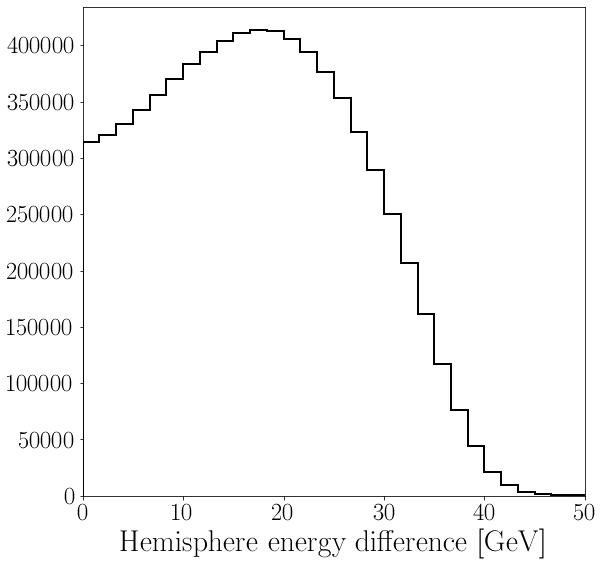

In [6]:
fig, ax = plt.subplots(figsize=(9,9))
plt.hist(events["EVT_thrutshemis_e_diff"],bins=30,range=(0,50),color="k",histtype='step',linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(0,50)
plt.xlabel("Hemisphere energy difference [GeV]",fontsize=30)
plt.show()
fig.savefig(f"{loc.PLOTS}/Bu2TauNu_diff_hemisphere_E.pdf")

In [7]:
#Look at charged and neutral multiplicities in the two hemispheres

#Events where hemisphere 0 is the minimum energy
events_hem0_min_cut = events["EVT_thrutshemis0_e"] == events["EVT_thrutshemis_e_min"]
events_hem0_min = events[events_hem0_min_cut]

#Events where hemisphere 1 is the minimum energy
events_hem1_min_cut = events["EVT_thrutshemis1_e"] == events["EVT_thrutshemis_e_min"]
events_hem1_min = events[events_hem1_min_cut]

#Get the charged and neutral energy and multiplicity
for ptype in ["charged","neutral"]:
    for var in ["n","e"]:
        events_hem0_min[f"{var}{ptype}_min"] = events_hem0_min[f"EVT_thrutshemis0_{var}{ptype}"]
        events_hem0_min[f"{var}{ptype}_max"] = events_hem0_min[f"EVT_thrutshemis1_{var}{ptype}"]
        
        events_hem1_min[f"{var}{ptype}_min"] = events_hem1_min[f"EVT_thrutshemis1_{var}{ptype}"]
        events_hem1_min[f"{var}{ptype}_max"] = events_hem1_min[f"EVT_thrutshemis0_{var}{ptype}"]

#Recombine
events = ak.concatenate([events_hem0_min,events_hem1_min],axis=0)

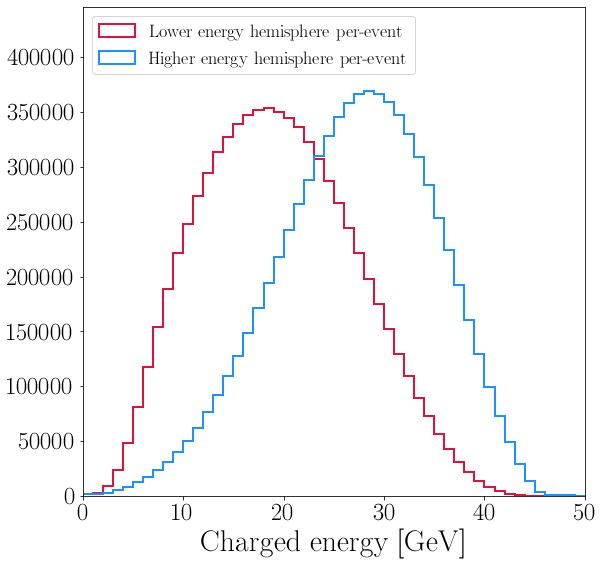

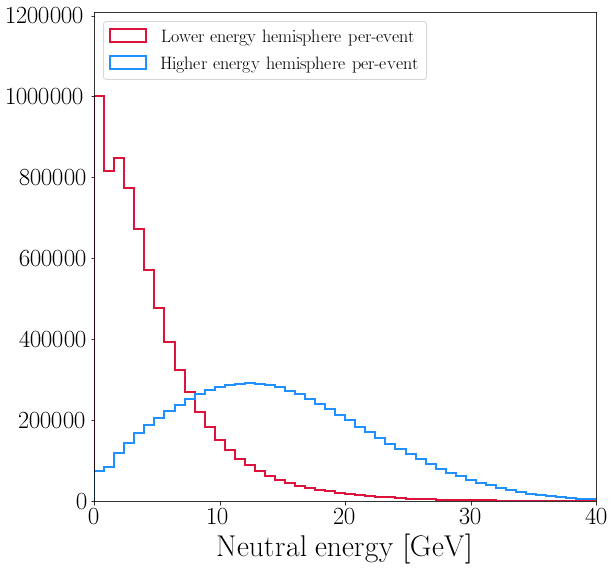

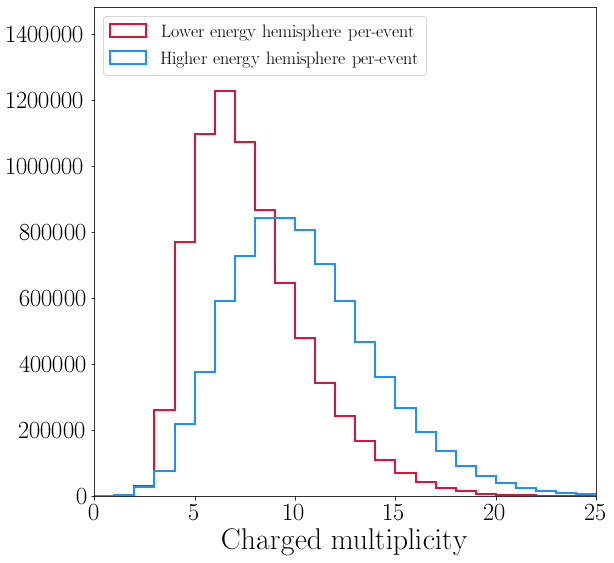

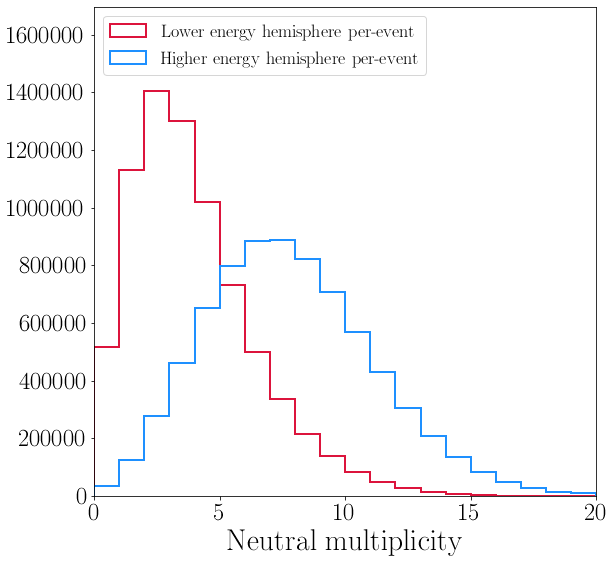

In [8]:
#Axis ranges, titles, and bins
plot_config = {"echarged": [0,50,"Charged energy [GeV]",50],
              "eneutral": [0,40,"Neutral energy [GeV]",50],
              "ncharged": [0,25,"Charged multiplicity",25],
              "nneutral": [0,20,"Neutral multiplicity",20]
              }

for p in plot_config:
    
    fig, ax = plt.subplots(figsize=(9,9))
    plt.hist(events[f"{p}_min"],bins=plot_config[p][3],range=(plot_config[p][0],plot_config[p][1]),color="crimson",histtype='step',linewidth=2,label="Lower energy hemisphere per-event")
    plt.hist(events[f"{p}_max"],bins=plot_config[p][3],range=(plot_config[p][0],plot_config[p][1]),color="dodgerblue",histtype='step',linewidth=2,label="Higher energy hemisphere per-event")
    ax.tick_params(axis='both', which='major', labelsize=25)
    plt.xlim(plot_config[p][0],plot_config[p][1])
    plt.xlabel(plot_config[p][2],fontsize=30)
    ymin,ymax = plt.ylim()
    plt.ylim(0,1.15*ymax)
    plt.legend(fontsize=18, loc="upper left")
    plt.show()
    fig.savefig(f"{loc.PLOTS}/Bu2TauNu_min_max_hemisphere_{p}.pdf")

In [9]:
df = pd.DataFrame()
persist_vars = ["EVT_e", #Total event visible energy
                "EVT_thrutshemis_e_min", #Lowest energy hemisphere in event
                "EVT_thrutshemis_e_max", #Highest energy hemisphere in event
                "EVT_thrutshemis0_e", #costheta < 0 hemisphere energy 
                "EVT_thrutshemis1_e", #costheta > 0 hemisphere energy
               ]
for var in ["e","n"]:
    for ptype in ["charged","neutral"]:
        for m in ["min","max"]:
            persist_vars.append(f"{var}{ptype}_{m}")

for var in persist_vars:
    df[var] = events[var].tolist()

#Save to CSV
df.to_csv(f"{loc.OUT}/csv/Bu2TauNu.csv")

#Write to ROOT file too
root_file_name = f"{loc.OUT}/ROOT/Bu2TauNu.root"
if os.path.exists(root_file_name):
    os.remove(root_file_name)
df.to_root(root_file_name,"events")